<a href="https://colab.research.google.com/github/AliceKitchkin/Unsupervised-Machine-Learning/blob/main/ECommerceCustomers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Als erstes Laufzeit neustarten

#1. Bibliotheken und Daten Import

In [1]:
# handle table-like data and matrices
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# pca
from sklearn.decomposition import PCA

# clustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# evaluations
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score, silhouette_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set float format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/Bachelorarbeit/CSV/E_Commerce_datasets/"

order_payments = pd.read_csv(path + "olist_order_payments_dataset.csv")
orders = pd.read_csv(path + "olist_orders_dataset.csv")
customers = pd.read_csv(path + "olist_customers_dataset.csv")
geolocation = pd.read_csv(path + "olist_geolocation_dataset.csv")
order_items = pd.read_csv(path + "olist_order_items_dataset.csv")
order_reviews = pd.read_csv(path + "olist_order_reviews_dataset.csv")
products = pd.read_csv(path + "olist_products_dataset.csv")
product_category_name_translation = pd.read_csv(path + "product_category_name_translation.csv")

del path

#2. Vorbereitung der Daten

##Spalten löschen

Aus Platzgründen kann ich nicht alle CSV-Dateien mergen, daher lösche ich vorab ein paar nicht benötigte Spalten.

In [4]:
orders = orders.drop(columns=['order_delivered_carrier_date', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'order_approved_at'])
customers = customers.drop(columns=['customer_unique_id'])
geolocation = geolocation.drop(columns=['geolocation_lat', 'geolocation_lng'])
order_items = order_items.drop(columns=['shipping_limit_date'])
order_reviews = order_reviews.drop(columns=['review_comment_title', 'review_comment_message'])
order_payments = order_payments.drop(columns=['payment_sequential'])
products = products.drop(columns=['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm'])

##Datensätze mergen und Spaltentypen ändern

Aus Platzgründen müssen zwischendurch die Spaltentypen geändert und Variablen gelöscht werden.

1.   Merge
2.   Spaltentyp ändern
3.   Variablen löschen

In [5]:
#order_payments & order_items
data = order_payments.merge(order_items, on='order_id')
data['payment_type'] = data['payment_type'].astype('category')
data['payment_installments'] = data['payment_installments'].astype('int16')
data['payment_value'] = data['payment_value'].astype('float16')
del order_payments, order_items

In [6]:
#orders
data = data.merge(orders, on='order_id')
data['order_status'] = data['order_status'].astype('category')
del orders

In [7]:
#customers
data = data.merge(customers, on='customer_id')
del customers

In [8]:
#geolocation
data = data.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
data['customer_city'] = data['customer_city'].astype('category')
data['customer_state'] = data['customer_state'].astype('category')
data = data.drop(columns=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'])
del geolocation

In [9]:
#order_reviews
data = data.merge(order_reviews, on='order_id')
data['review_score'] = data['review_score'].astype('int16')
del order_reviews

In [10]:
#products
data = data.merge(products, on='product_id')
del products

In [11]:
#product_category_name_translation
data = data.merge(product_category_name_translation, on='product_category_name')
data['product_category_name_english'] = data['product_category_name_english'].astype('category')
data = data.drop(columns=['product_category_name'])
del product_category_name_translation

Jetzt können die restlichen Spaltentypen geändert werden

In [13]:
data['order_id'] = data['order_id'].astype('string')
data['order_item_id'] = data['order_item_id'].astype('string')
data['product_id'] = data['product_id'].astype('string')
data['seller_id'] = data['seller_id'].astype('string')
data['customer_id'] = data['customer_id'].astype('string')
data['review_id'] = data['review_id'].astype('string')
# data['order_purchase_timestamp'] = data['order_purchase_timestamp'].astype('X')
# data['review_creation_date'] = data['review_creation_date'].astype('X')
# data['review_answer_timestamp'] = data['review_answer_timestamp'].astype('X')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17658865 entries, 0 to 17658864
Data columns (total 20 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   order_id                       string  
 1   payment_type                   category
 2   payment_installments           int16   
 3   payment_value                  float16 
 4   order_item_id                  string  
 5   product_id                     string  
 6   seller_id                      string  
 7   price                          float64 
 8   freight_value                  float64 
 9   customer_id                    string  
 10  order_status                   category
 11  order_purchase_timestamp       object  
 12  customer_zip_code_prefix       int64   
 13  customer_city                  category
 14  customer_state                 category
 15  review_id                      string  
 16  review_score                   int16   
 17  review_creation_date     

Von 2,9 GB auf 1,9 GB reduziert

##Leere Werte checken

In [15]:
#before mean fill
data.isnull().sum()

order_id                         0
payment_type                     0
payment_installments             0
payment_value                    0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
review_id                        0
review_score                     0
review_creation_date             0
review_answer_timestamp          0
product_category_name_english    0
dtype: int64

##DataFrame als CSV speichern und auslesen

In [16]:
import os

path_file = "/content/drive/MyDrive/Bachelorarbeit/CSV/E_Commerce_datasets/ECommerce_merged.csv"

if os.path.exists(path_file):
  os.remove(path_file)
  data.to_csv(path_file)
  data = pd.read_csv(path_file)
else:
  data.to_csv(path_file)
  data = pd.read_csv(path_file)

del path_file

In [17]:
data = pd.read_csv("/content/drive/MyDrive/Bachelorarbeit/CSV/E_Commerce_datasets/ECommerce_merged.csv")

In [19]:
#Woher auch immer kommt die Spalte "Unnamed: 0" dazu, löschen:
data = data.drop(columns=['Unnamed: 0'])

#3. Überblick verschaffen

In [20]:
data.head()

,order_id,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_creation_date,review_answer_timestamp,product_category_name_english
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.3,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
1,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.3,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
2,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.3,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
3,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.3,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
4,b81ef226f3fe1789b1e8b2acac839d17,credit_card,8,99.3,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction


In [21]:
data.shape

(17658865, 20)

In [24]:
data.describe()

,payment_installments,payment_value,order_item_id,price,freight_value,customer_zip_code_prefix,review_score
count,17658865.000,17658865.000,17658865.000,17658865.000,17658865.000,17658865.000,17658865.000
mean,2.939,174.482,1.205,121.460,19.644,32717.958,4.033
std,2.800,266.829,0.698,185.543,14.998,26979.151,1.398
min,0.000,0.000,1.000,0.850,0.000,1003.000,1.000
25%,1.000,61.750,1.000,39.900,13.470,13140.000,4.000
50%,1.000,109.800,1.000,74.990,16.270,23860.000,5.000
75%,4.000,192.100,1.000,135.000,20.400,38400.000,5.000
max,24.000,13660.000,21.000,6735.000,409.680,99980.000,5.000


#Feature Scaling ALT

In [ ]:
data.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_city,geolocation_state,review_id,review_score,review_creation_date,review_answer_timestamp,product_category_name_english
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
1,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,39801,teófilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
2,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
3,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction
4,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,79.8,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,39801,teofilo otoni,MG,39801,teofilo otoni,MG,4ce650e117a5b292bf5ea980a61eb61e,1,2018-05-10 00:00:00,2018-05-15 23:38:00,home_construction


In [ ]:
groupedby_product_id = data.groupby('product_id').sum()
groupedby_product_id.drop(columns=['payment_sequential', 'payment_installments', 'customer_zip_code_prefix', 'geolocation_zip_code_prefix'])
groupedby_product_id

,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,customer_zip_code_prefix,geolocation_zip_code_prefix,review_score
product_id,,,,,,,,,
00066f42aeeb9f3007548bb9d3f33c38,153,459,18396.72,153,15552.45,2844.27,14671170,14671170,765
00088930e925c41fd95ebfe695fd2655,438,438,62997.54,438,56896.20,6101.34,6308514,6308514,1752
0009406fd7479715e4bef61dd91f2462,44,440,10652.40,44,10076.00,576.40,126852,126852,44
000b8f95fcb9e0096488278317764d19,42,81,3297.00,42,2473.80,823.20,3949632,3949632,210
000d9be29b5207b54e86aa1b1ac54872,115,345,25101.05,115,22885.00,2216.05,556945,556945,575
...,...,...,...,...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,69,330,9924.38,69,7959.31,1965.07,3234380,3234380,308
fff81cc3158d2725c0655ab9ba0f712c,33,33,3230.37,33,2970.00,260.37,179487,179487,132
fff9553ac224cec9d15d49f5a263411f,117,117,5130.45,117,3744.00,1386.45,1895517,1895517,585


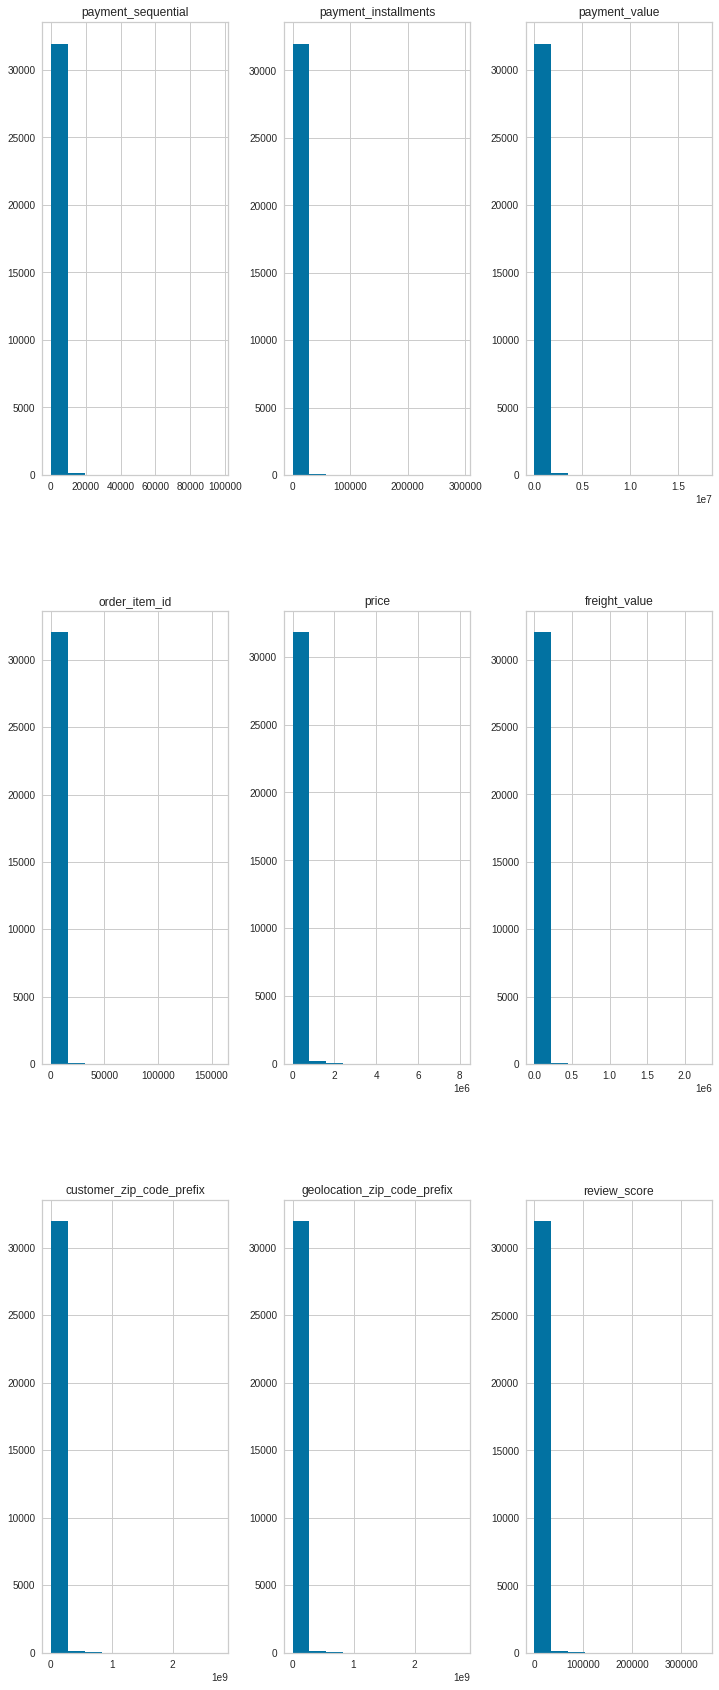

In [ ]:
#data before scaling
groupedby_product_id.hist(figsize=(12,30));

In [ ]:
#Scaling with minMaxScaler from 1 to 10
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
df_data_scaled = pd.DataFrame(data_scaled, columns=features)

In [ ]:
#after scaling
df_data_scaled.head()

,overall,potential,wage_eur,value_eur,age
0,1.000000,0.956522,0.914163,0.402034,0.473684
1,0.978261,0.934783,0.771102,0.615962,0.421053
2,0.956522,0.913043,0.771102,0.231923,0.526316
3,0.956522,0.913043,0.771102,0.664933,0.342105
4,0.956522,0.913043,1.000000,0.646891,0.368421


In [ ]:
#after scaling
df_data_scaled.describe()

,overall,potential,wage_eur,value_eur,age
count,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000
mean,0.408091,0.479986,0.024372,0.014647,0.242390
std,0.149570,0.132309,0.055620,0.039172,0.124954
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.304348,0.391304,0.001431,0.002402,0.131579
50%,0.413043,0.478261,0.007153,0.004980,0.236842
75%,0.500000,0.565217,0.021459,0.010779,0.342105
max,1.000000,1.000000,1.000000,1.000000,1.000000


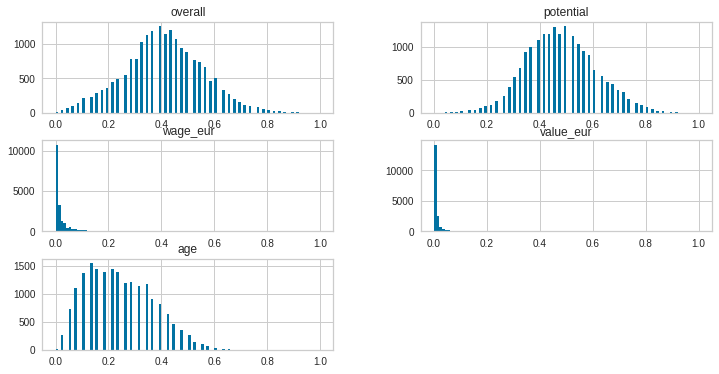

In [ ]:
#after scaling
df_data_scaled.hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

#PCA 2D  ALT

PCA to visualize 5 features (the 5 columns from the data above) in a 2 dimension plot (5D to 2D)

In [ ]:
pca = PCA(n_components=2) #2D for the plot
data_2d = pd.DataFrame(pca.fit_transform(data_scaled)) #runs the model on the data

In [ ]:
data_2d

,0,1
0,0.992422,-0.011649
1,0.951683,-0.052496
2,0.897109,0.058406
3,0.911658,-0.110470
4,0.959746,-0.093122
...,...,...
19234,-0.567194,0.093158
19235,-0.501904,-0.055433
19236,-0.537682,0.035603
19237,-0.490019,-0.067495


#PCA 3D  ALT

PCA to visualize 5 features (the 5 columns from the data above) in a 3 dimension plot (5D to 3D)

In [ ]:
pca3 = PCA(n_components=3) #3D for the plot
data_3d = pd.DataFrame(pca3.fit_transform(data_scaled)) #runs the model on the data

In [ ]:
data_3d

,0,1,2
0,0.992422,-0.011649,0.729231
1,0.951683,-0.052496,0.736588
2,0.897109,0.058406,0.534668
3,0.911658,-0.110470,0.776906
4,0.959746,-0.093122,0.950269
...,...,...,...
19234,-0.567194,0.093158,0.119716
19235,-0.501904,-0.055433,0.089415
19236,-0.537682,0.035603,0.105367
19237,-0.490019,-0.067495,0.084133


#Clustering  ALT

##Elbow Method

To find the optimal number of cluster

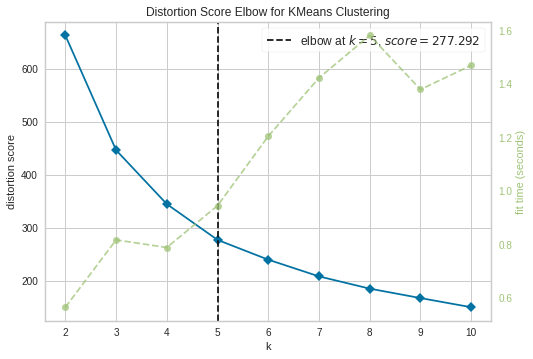

In [ ]:
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(data_2d)
elbow.show()

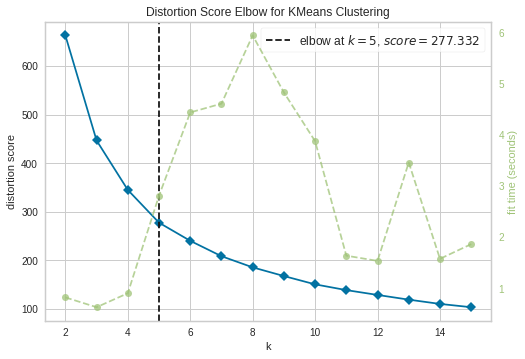

In [ ]:
elbow15 = KElbowVisualizer(KMeans(), k=15)
elbow15.fit(data_2d)
elbow15.show()

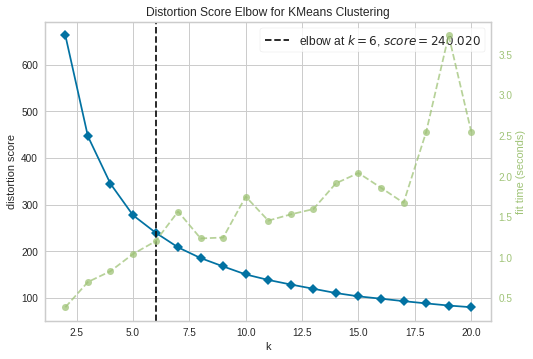

In [ ]:
elbow20 = KElbowVisualizer(KMeans(), k=20)
elbow20.fit(data_2d)
elbow20.show()

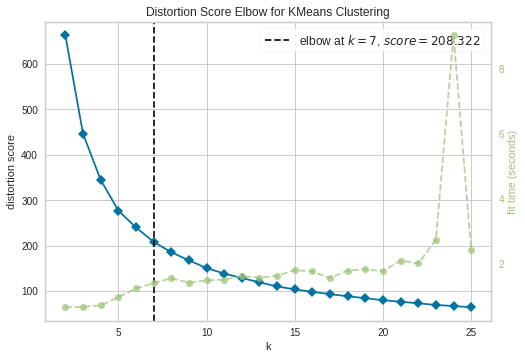

In [ ]:
elbow25 = KElbowVisualizer(KMeans(), k=25)
elbow25.fit(data_2d)
elbow25.show()

##Silhouette Score

0.35899689108217797


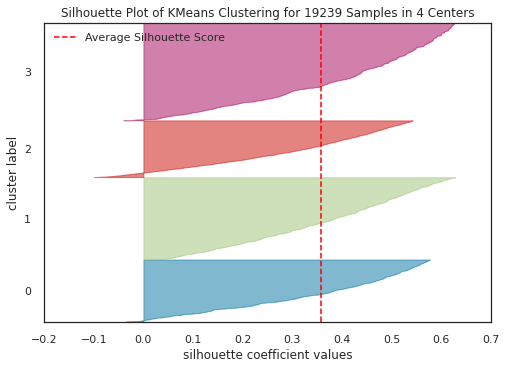

In [ ]:
kmeans4 = KMeans(n_clusters = 4, random_state=42)
visualizer4 = SilhouetteVisualizer(kmeans4, colors='yellowbrick')
visualizer4.fit(data_2d)

print(visualizer4.silhouette_score_)
visualizer4.show()

0.3536718465206499


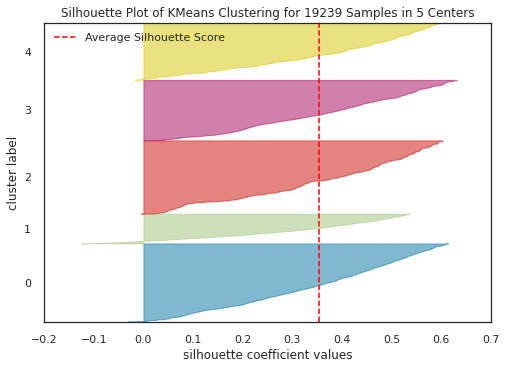

In [ ]:
kmeans5 = KMeans(n_clusters = 5, random_state=42)
visualizer5 = SilhouetteVisualizer(kmeans5, colors='yellowbrick')
visualizer5.fit(data_2d)

print(visualizer5.silhouette_score_)
visualizer5.show()

0.33638322696062223


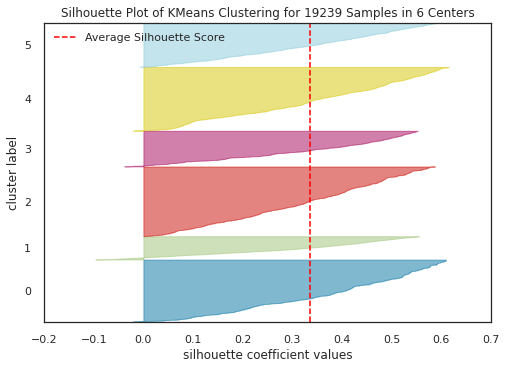

In [ ]:
kmeans6 = KMeans(n_clusters = 6, random_state=42)
visualizer6 = SilhouetteVisualizer(kmeans6, colors='yellowbrick')
visualizer6.fit(data_2d)

print(visualizer6.silhouette_score_)
visualizer6.show()

0.3358255408670007


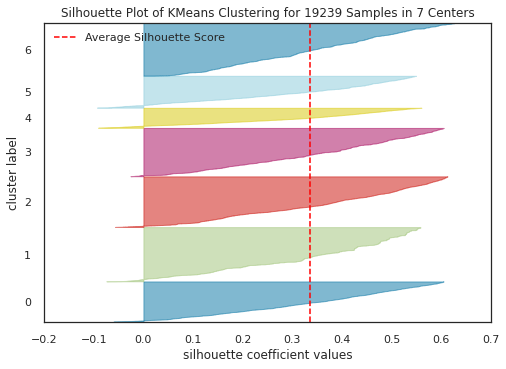

In [ ]:
kmeans7 = KMeans(n_clusters = 7, random_state=42)
visualizer7 = SilhouetteVisualizer(kmeans7, colors='yellowbrick')
visualizer7.fit(data_2d)

print(visualizer7.silhouette_score_)
visualizer7.show()

##K-Means

In [ ]:
#specify the number of clusters we got from silhouette score
kmeans = KMeans(n_clusters=5)

In [ ]:
#fit the scaled data
kmeans = kmeans.fit(data_2d)

In [ ]:
#get the cluster labels
labels = kmeans.predict(data_2d)

In [ ]:
#get the centroid values
centroids = kmeans.cluster_centers_

In [ ]:
#get the cluster values
clusters = kmeans.labels_.tolist()

##Visualization 2D

In [ ]:
data_v_2d = data_2d.copy()

In [ ]:
#add new column for cluster
data_v_2d['cluster'] = clusters

#add new column for player names
names = data_players.short_name.tolist()
data_v_2d['name'] = names

data_v_2d.columns = ['x', 'y', 'cluster', 'name']

In [ ]:
data_v_2d.head()

,x,y,cluster,name
0,0.992422,-0.011649,4,L. Messi
1,0.951683,-0.052496,4,R. Lewandowski
2,0.897109,0.058406,4,Cristiano Ronaldo
3,0.911658,-0.110470,4,Neymar Jr
4,0.959746,-0.093122,4,K. De Bruyne


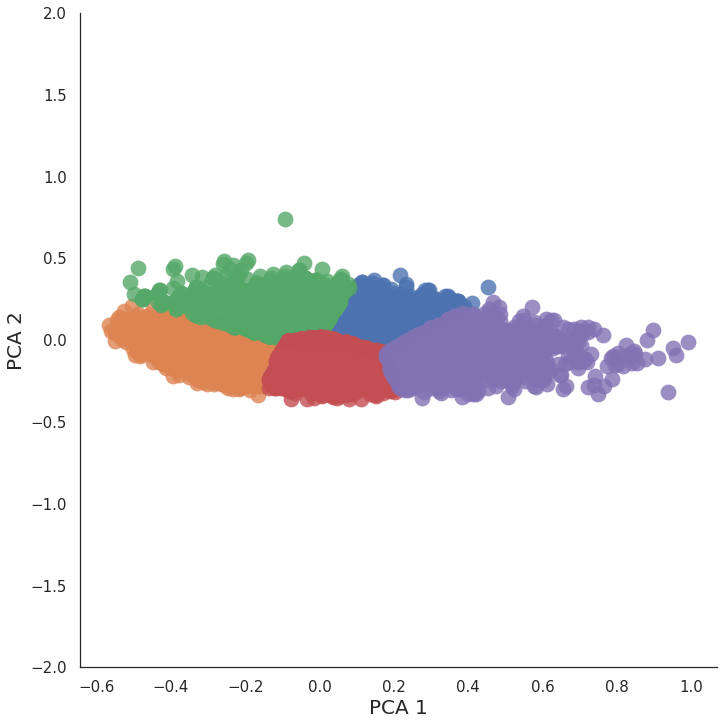

In [ ]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue="cluster", data=data_v_2d, legend=False, fit_reg=False, size=10, scatter_kws={'s':250})

# texts = []
# for x, y, n in zip (data_v.x, data_v.y, data_v.name):
#   texts.append(plt.text(x, y, n))

ax.set(ylim=(-2,2))
plt.tick_params(labelsize=15)
plt.xlabel("PCA 1", fontsize=20)
plt.ylabel("PCA 2", fontsize=20)

plt.show()

##Visualization 3D

In [ ]:
data_v_3d = data_3d.copy()

In [ ]:
#add new column for cluster
data_v_3d['cluster'] = clusters

#add new column for player names
names = data_players.short_name.tolist()
data_v_3d['name'] = names

data_v_3d.columns = ['x', 'y', 'z', 'cluster', 'name']

In [ ]:
data_v_3d.head()

,x,y,z,cluster,name
0,0.992422,-0.011649,0.729231,4,L. Messi
1,0.951683,-0.052496,0.736588,4,R. Lewandowski
2,0.897109,0.058406,0.534668,4,Cristiano Ronaldo
3,0.911658,-0.110470,0.776906,4,Neymar Jr
4,0.959746,-0.093122,0.950269,4,K. De Bruyne


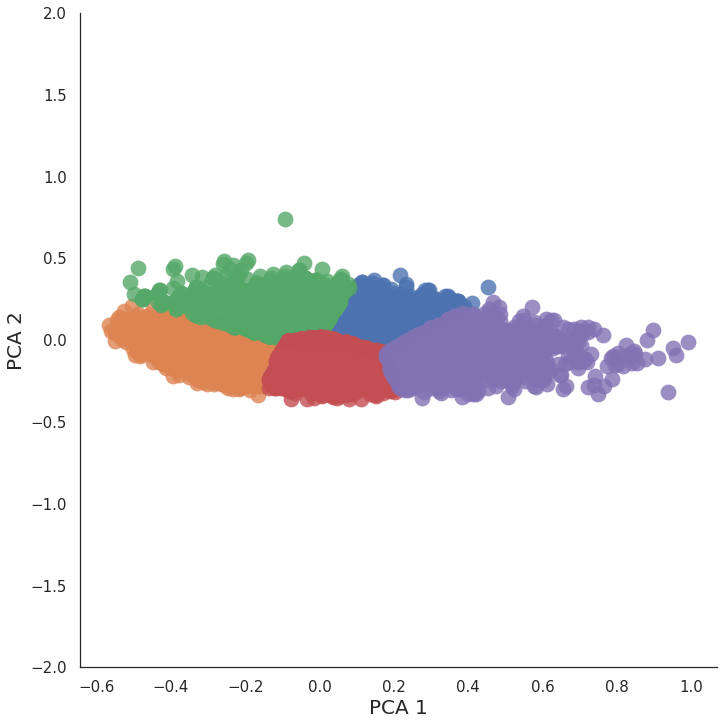

In [ ]:
sns.set(style="white")

ax = sns.lmplot(x="x", y="y", hue="cluster", data=data_v_3d, legend=False, fit_reg=False, size=10, scatter_kws={'s':250})

# texts = []
# for x, y, n in zip (data_v.x, data_v.y, data_v.name):
#   texts.append(plt.text(x, y, n))

ax.set(ylim=(-2,2))
plt.tick_params(labelsize=15)
plt.xlabel("PCA 1", fontsize=20)
plt.ylabel("PCA 2", fontsize=20)

plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(data_v_3d, x='x', y='y', z='z', log_x=True, hover_name="name", hover_data=["name"], color='cluster')
fig.show()